<a href="https://colab.research.google.com/github/kirannkrishna-it21/WASTE-CLASSIFICATION/blob/main/waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
DIR = "/content/drive/MyDrive/WasteImagesDataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

Found 1831 files belonging to 5 classes.
Using 1648 files for training.
Found 1831 files belonging to 5 classes.
Using 183 files for validation.


In [ ]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


['Organic Waste', 'Paper', 'Plastic', 'Textiles', 'Wood']


In [ ]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)

12683000/12683000 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 5
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/5


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 487s 20s/step - loss: 351.0664 - accuracy: 0.5922 - val_loss: 270.5601 - val_accuracy: 0.8852
Epoch 2/5
13/13 [==============================] - 118s 9s/step - loss: 217.1547 - accuracy: 0.9011 - val_loss: 160.6733 - val_accuracy: 0.9016
Epoch 3/5
13/13 [==============================] - 111s 8s/step - loss: 124.2442 - accuracy: 0.9302 - val_loss: 86.9259 - val_accuracy: 0.9180
Epoch 4/5
13/13 [==============================] - 109s 8s/step - loss: 64.0413 - accuracy: 0.9551 - val_loss: 41.4909 - val_accuracy: 0.9180
Epoch 5/5
13/13 [==============================] - 118s 9s/step - loss: 28.8763 - accuracy: 0.9624 - val_loss: 17.1900 - val_accuracy: 0.9290


In [ ]:
path = "/content/drive/MyDrive/WasteImagesDataset/Paper/paper1.jpg"


img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

1/1 [==============================] - 1s 1s/step


[0, 4, 0, 0, 1, 2, 2, 1, 1, 4, 0, 4, 0, 4, 1, 1, 0, 3]
Prediction: Paper


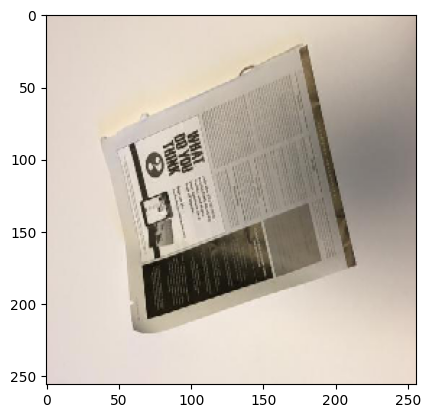

In [ ]:
plt.imshow(img)
print(predictions)
print("Prediction: " + str(classes[np.argmax(predictions)]))


2/2 [==============================] - 4s 960ms/step


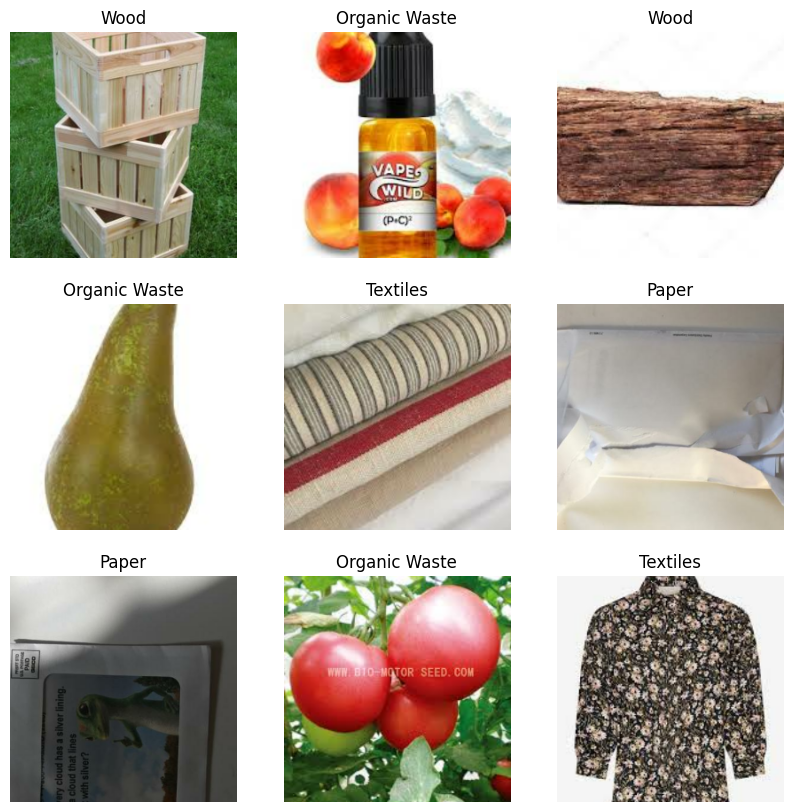

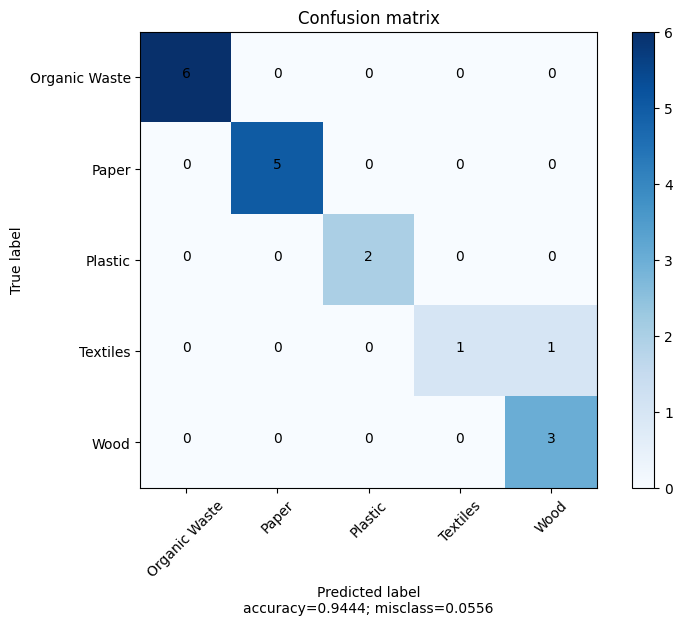

In [ ]:
#MODEL EVALUATION

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

for images, labels in test_dataset.take(10):
  pred = model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

    true.append(labels[i])
    predictions.append(np.argmax(pred[i]))

    plt.title(classes[labels[i]])
    plt.axis("off")

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)